## Introduction to Langgraph and SambaNova

LangGraph provides low-level supporting infrastructure for any long-running, stateful workflow or agent.

For this example, we use LangGraph and the SambaNovaCloud LLM to create a chatbot that integrates a web search tool. The chatbot can use this tool to find relevant information and provide more accurate responses.

## Install dependencies

In [ ]:
!pip install -U langchain-tavily
!pip install langchain-sambanova
!pip install langchain
!pip install langgraph

## Set up the environment, tools and llm

In [ ]:
import os

os.environ["SAMBANOVA_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""

In [2]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]

In [ ]:
from langchain_sambanova import ChatSambaNovaCloud

llm = ChatSambaNovaCloud(
    model="Meta-Llama-3.3-70B-Instruct",
    max_tokens=1024,
    temperature=0.7,
    top_p=0.01,
)

## Build the graph

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [5]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [6]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

## Display the graph

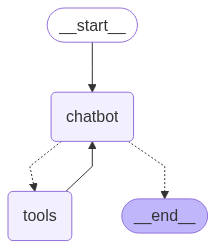

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Ask the chatbot questions

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about SambaNova Systems?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
User: What do you know about SambaNova Systems?
Assistant: 
Assistant: {"query": "SambaNova Systems", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.businesswire.com/news/home/20250318772992/en/SambaNova-Named-4-on-Fast-Companys-Most-Innovative-Companies-of-2025-List", "title": "SambaNova Named #4 on Fast Company's Most Innovative ...", "content": "Headquartered in Palo Alto, California, SambaNova Systems was founded in 2017 by industry luminaries, and hardware and software design experts from Sun/Oracle and Stanford University. Investors include SoftBank Vision Fund 2, funds and accounts managed by BlackRock, Intel Capital, GV, Walden International, Temasek, GIC, Redline Capital, Atlantic Bridge Ventures, Celesta, and several others. Visit us at [...] \u201cSambaNova is leading the next wave of enterprise AI, delivering real-time inference at unmatched speed and efficiency,\u201d said Rodrigo Liang, CEO and co-founder of SambaNo